In [4]:
### GENERAL REQUIREMENTS - will install the libraries

import pandas as pd
import numpy as np
import math
import nltk
import requests
import re
import json
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import geopandas
from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot

from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [5]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
occupations = gc.open_by_url("https://docs.google.com/spreadsheets/d/1nONTEwp42CVnq3iCiONrFbJedIcYtBV-l4Bil5mU7Eo/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [6]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [195]:
# read the datasets
publicfolder = "e0f9cd400dd05584fe06fe1d804deff0"
EDH = sddk.read_file("EDH_occupsorgs_2021-02-26.json", "df", publicfolder)
EDCS = sddk.read_file("EDCS_occupsorgs_2021-02-26.json", "df", publicfolder)

reading file located in a public folder
reading file located in a public folder


In [196]:
# length of the original dataset
print(len(EDH))
print(len(EDCS))

81476
500618


# Filter by language

In [217]:
# focus on latin inscriptions only
EDH = EDH[EDH["language"].notnull()]
EDH = EDH[EDH["language"].str.contains("Latin")]
print(len(EDH))

# focus on latin inscriptions only
EDCS = EDCS[EDCS["language"].isnull()]
print(len(EDCS))

80177
98825


# Remove EDH by Links

In [198]:
# identify overlapping inscriptions
links_with_edh = EDCS[EDCS["Links"].str.contains("edh", na=False)]["Links"].tolist()
edh_ids = [link.rpartition("edh/inschrift/")[2].split()[0] for link in links_with_edh]


In [199]:
# remove them from the dataset
EDCS = EDCS[~EDCS["Links"].str.contains("edh", na=False)]
len(EDCS)

405372

In [376]:
pd.options.display.max_columns = 1000

# Filter by dating

In [200]:
# having at least some form of date
EDCS = EDCS[(EDCS["dating from"].notnull()) | (EDCS["dating to"].notnull())]
len(EDCS)

98972

In [207]:
# this date being numeric
def to_int(date_str):
    try: return int(date_str)
    except: return None
    
EDCS["dating from"] = EDCS["dating from"].apply(to_int)
EDCS["dating to"] = EDCS["dating to"].apply(to_int)

In [405]:
# this date within the desired range
EDCS = (EDCS[(EDCS["dating from"].between(-50, 350) | (EDCS["dating to"].between(-50, 350)))])
len(EDCS)

88270

In [429]:
len(EDH)

80177

In [433]:
# this date within the desired range
EDH["not_before"] = EDH["not_before"].apply(to_int)
EDH["not_after"] = EDH["not_after"].apply(to_int)

EDH = EDH[(EDH["not_before"].between(-50, 350) | (EDH["not_after"].between(-50, 350)))]
len(EDH)

56466

# Deduplicate EDH & EDCS

In [214]:
len(edh_ids)

72177

In [218]:
# inscriptions only in EDH
EDH_unique = EDH[~EDH["id"].isin(edh_ids)]
len(EDH_unique)

9250

# Using identity in textual content and spatial proximity

In [219]:
# having at least some text
EDH_unique = EDH_unique[EDH_unique["clean_text_interpretive_word"].notnull()]
len(EDH_unique)

9247

In [220]:
EDH_unique_dict = {}
EDH_unique_tups = [tup for tup in zip(EDH_unique["clean_text_interpretive_word"].tolist(), EDH_unique["id"])]
for text, edh_id in EDH_unique_tups:
    EDH_unique_dict[text] = [tup[1] for tup in EDH_unique_tups if tup[0] == text]

In [221]:
len(EDH_unique_dict)

8420

In [222]:
def match_text(edcs_str):
    try: return EDH_unique_dict[edcs_str]
    except: return None
    
EDCS["edh_candidates"] = EDCS["clean_text_interpretive_word"].apply(match_text)

In [223]:
len(EDCS[EDCS["edh_candidates"].notnull()])

4849

In [224]:
EDCS[EDCS["edh_candidates"].notnull()].head(5)

,EDCS-ID,publication,province,place,notes_dating,notes_references,notes_comments,inscription,inscription_stripped14,clean_text_interpretive_word,...,Latitude,Longitude,photo,Material,Comment,occups,occups_N,organizations,organizations_N,edh_candidates
2700,EDCS-58200154,Didymoi 00229,Aegyptus,Dios / Latomia Dios / Didymoi,,,,[3[[3 ni]]],[3[[3 ni]]],ni,...,25.187415,34.086320,None,opus figlinae,None,[],0,[],0,[HD077582]
3502,EDCS-47900995,"CIL 11, 06712,499a = InstrInscr-05, p 340,50",Aemilia / Regio VIII,Bologna / Bononia,,,,Ut(ere) f(elix),Ut(ere) f(elix),Utere felix,...,44.4938605,11.3429718,None,None,None,[],0,[],0,[HD080742]
4370,EDCS-08100097,"SupIt-17-Fe, 00034",Aemilia / Regio VIII,Ferrara,,,,?,?,,...,44.8372737,11.6186451,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,lapis,unleserlicher Text,[],0,[],0,"[HD079887, HD081183, HD081185, HD081194, HD081..."
4497,EDCS-10900004,"SupIt-10-FL, 00004",Aemilia / Regio VIII,Forli / Forum Livii,,,,]AI[,]AI[,AI,...,44.2227182,12.0412435,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,[],0,[],0,"[HD077256, HD078436, HD079814]"
4498,EDCS-10900005,"SupIt-10-FL, 00005",Aemilia / Regio VIII,Forli / Forum Livii,,,,]F[,]F[,F,...,44.2227182,12.0412435,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,[],0,[],0,"[HD077079, HD077081, HD079363, HD079364]"


In [371]:
thresh = 1

def evaluate_candidates(edcs_row):
    spatial_differences = []
    try:
        long_x, lat_y = float(edcs_row["Longitude"]), float(edcs_row["Latitude"])
        for edh_candidate_id in edcs_row["edh_candidates"]:
            edh_candidate_row = EDH_unique.loc[EDH_unique["id"]==edh_candidate_id]
            edh_long_x, edh_lat_y = edh_candidate_row["coordinates"][0][0], edh_candidate_row["coordinates"][0][1]
            long_dif = abs(edh_long_x - long_x)
            lat_dif = abs(edh_lat_y - lat_y)
            if ((long_dif < thresh) & (lat_dif < thresh)):
                spatial_differences.append([edcs_row["EDCS-ID"], [long_x, lat_y], edh_candidate_id, [edh_long_x, edh_lat_y], long_dif, lat_dif])
    except: 
        #print("not working")
        pass
    return spatial_differences

In [373]:
edcs_edh = [el for el in EDCS[EDCS["edh_candidates"].notnull()].apply(lambda row: evaluate_candidates(row), axis=1).tolist() if len(el) > 0]
edcs_edh

[[['EDCS-57600020',
   [7.0539789, 45.1372115],
   'HD065962',
   [7.0482, 45.1379],
   0.005778900000000142,
   0.0006885000000025343]],
 [['EDCS-31300280',
   [35.766667, 31.0],
   'HD023381',
   [35.8757, 31.417],
   0.10903300000000371,
   0.4170000000000016]],
 [['EDCS-10700576',
   [7.187221, 51.7430516],
   'HD080265',
   [7.1872, 51.7431],
   2.1000000000270802e-05,
   4.839999999717293e-05]],
 [['EDCS-75000269',
   [6.9487853, 51.0528023],
   'HD081817',
   [6.9488, 51.0528],
   1.4700000000367197e-05,
   2.300000005561742e-06]],
 [['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD079887',
   [6.0838, 50.7754],
   0.3146865999999999,
   0.8340731999999988],
  ['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD081183',
   [6.9597, 50.9401],
   0.5612133999999998,
   0.9987732000000022],
  ['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD081185',
   [6.9597, 50.9401],
   0.5612133999999998,
   0.9987732000000022],
  ['EDCS-10601218',
   [6.3984866, 49.9413268],
   'HD08119

In [380]:
len(edcs_edh)

643

# Using trismegistos API

In [389]:
def get_edcs(trismegistos_uri):
    try:
        url = "https://www.trismegistos.org/dataservices/texrelations/{}".format(trismegistos_uri.rpartition("/")[2])
        resp = requests.get(url)
        edcs_ids = resp.json()[3]["EDCS"]
        return edcs_ids
    except: 
        return None

In [390]:
%%time
EDH_unique["edcs_ids"] = EDH_unique["trismegistos_uri"].apply(get_edcs)

CPU times: user 1min 51s, sys: 2.86 s, total: 1min 54s
Wall time: 14min 17s


In [396]:
edcs_to_edh_dict = {}
for edh_id, edcs_ids in zip(EDH_unique["id"], EDH_unique["edcs_ids"]):
    try:
        for edcs_id in edcs_ids:
            edcs_to_edh_dict["EDCS-" + edcs_id] = edh_id
    except:
        pass

In [399]:
sddk.write_file("SDAM_data/social_diversity/edcs_to_edh_dict.json", edcs_to_edh_dict, conf)

A file with the same name ("edcs_to_edh_dict.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/edcs_to_edh_dict.json"


In [398]:
len(EDCS)

98825

In [403]:
len(edcs_to_edh_dict)

5483

In [401]:
edcs_edh_keys = list(edcs_to_edh_dict.keys())

In [406]:
len(EDCS[~EDCS["EDCS-ID"].isin(edcs_edh_keys)])

88088

# Create geodataframes

In [434]:
# EDH as geodataframe
EDHg = EDH[EDH["coordinates"].apply(lambda x: isinstance(x, list))]
EDHg = geopandas.GeoDataFrame(EDHg, geometry=geopandas.points_from_xy(EDHg["coordinates"].apply(lambda x: x[0]), EDHg["coordinates"].apply(lambda x: x[1])), crs={"init": "epsg:3857"})

In [407]:
# EDCS as geodataframe
EDCS = EDCS[EDCS["Latitude"].notnull()]
EDCSg = geopandas.GeoDataFrame(EDCS, geometry=geopandas.points_from_xy(EDCS["Longitude"], EDCS["Latitude"]))

# Import regions

In [412]:
### # pelagios provinces - only for plotting purposes
url = "https://raw.githubusercontent.com/pelagios/magis-pleiades-regions/main/pleiades-regions-magis-pelagios.geojson"
pleiades_regions = geopandas.read_file(url, crs={"init": "epsg:3857"})
pleiades_regions.head()

,name,uri,geometry
0,Lusitania,http://pleiades.stoa.org/places/1101,"POLYGON ((-7.31057 37.19663, -7.32457 37.19556..."
1,Byzacena,http://pleiades.stoa.org/places/991345,"MULTIPOLYGON (((11.01815 34.62424, 11.00879 34..."
2,Viennensis,http://pleiades.stoa.org/places/992074,"POLYGON ((4.62344 45.60642, 4.71224 45.60876, ..."
3,Lycia et Pamphylia,http://pleiades.stoa.org/places/981530,"MULTIPOLYGON (((29.62331 36.07470, 29.61295 36..."
4,Savia,http://pleiades.stoa.org/places/991357,"POLYGON ((18.10598 45.77203, 18.10654 45.71079..."


In [19]:
# merge the regions into one multipolygon
RE_merged = pleiades_regions.unary_union

In [413]:
def re_by_id(id, dataset=None):
    if dataset == "EDH":
        try: return EDH_within_RE_dict[id]
        except: return False
    elif dataset == "EDCS":
        try: return EDCS_within_RE_dict[id]
        except: return False
    else:
        return False

In [435]:
# previously computed inscriptions within RE
EDH_within_RE_dict = sddk.read_file("SDAM_data/social_diversity/EDH_within_RE_dict.json", "dict", conf)
EDHg["within_RE"]= EDHg["id"].apply(re_by_id, dataset="EDH")
# to recompute, uncomment the following (takes approx five minutes):
#EDHg["within_RE"] = EDHg.within(RE_merged)
#EDH_within_RE_dict = dict(zip(EDHg["id"].tolist(), EDHg["within_RE"]))
#sddk.write_file("SDAM_data/social_diversity/EDH_within_RE_dict.json", EDH_within_RE_dict, conf)

In [415]:
%%time
EDCS_within_RE_dict = sddk.read_file("SDAM_data/social_diversity/EDCS_within_RE_dict.json", "dict", conf)
EDCSg["within_RE"]= EDCSg["EDCS-ID"].apply(re_by_id, dataset="EDCS")
# to recompute, uncomment the following (takes approx 30 minutes):
#EDCSg["within_RE"] = EDCSg.within(RE_merged)
#EDCS_within_RE_dict = dict(zip(EDCSg["EDCS-ID"].tolist(), EDCSg["within_RE"]))
#sddk.write_file("SDAM_data/social_diversity/EDCS_within_RE_dict.json", EDCS_within_RE_dict, conf)

CPU times: user 283 ms, sys: 16 ms, total: 299 ms
Wall time: 753 ms


In [436]:
EDHg = EDHg[EDHg["within_RE"]==True]
EDCSg = EDCSg[EDCSg["within_RE"]==True]

In [437]:
print(len(EDHg))
print(len(EDCSg))

52708
83656


Text(0.5, 1.0, 'EDCS latin (N=83656)')

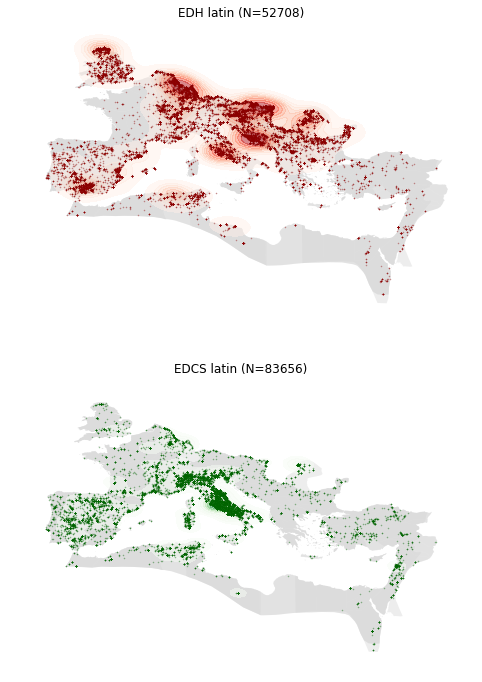

In [438]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=[24, 12])

pleiades_regions.plot(ax=ax1, color="lightgray", alpha=0.4)
geoplot.kdeplot(EDHg, cmap='Reds', shade=True, alpha=0.5, ax=ax1) # , clip=EDHg.geometry,
EDHg.plot(ax=ax1, alpha=0.4, color="darkred", markersize=0.3)
ax1.set_axis_off()
ax1.set_title("EDH latin (N={0})".format(len(EDHg)))

pleiades_regions.plot(ax=ax2, color="lightgray", alpha=0.4)
geoplot.kdeplot(EDCSg, cmap='Greens', shade=True, alpha=0.5, ax=ax2) # , clip=EDHg.geometry,
EDCSg.plot(ax=ax2, alpha=0.4, color="darkgreen", markersize=0.3)
ax2.set_axis_off()
ax2.set_title("EDCS latin (N={0})".format(len(EDCSg)))

# Occupations and organizations in urban vs rural context

In [422]:
cities_pop = geopandas.GeoDataFrame(cities_pop, geometry=geopandas.points_from_xy(cities_pop["Longitude (X)"], cities_pop["Latitude (Y)"]), crs={"init":"epsg:3857"})

In [31]:
cities_pop.sort_values("pop_est", ascending=False, inplace=True)

In [32]:
len(cities_pop)

1388

In [41]:
# total urban population
cities_pop["pop_est"].sum()

10159670.0

In [42]:
# size of urban population living within 50 biggest cities
cities_pop["pop_est"][:50].sum()

4059005.0

In [43]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Longitude (X)', 'Latitude (Y)',
       'Select Bibliography', 'Area', 'Estimate Basis', 'Civic Status',
       'Structure', 'num_of_structures', 'ID', 'pop_sample', 'pop_est',
       'pop_diff', 'geometry'],
      dtype='object')

In [44]:
# create two groups of cities
cities_big = cities_pop[cities_pop["pop_est"] >= 30000]
cities_rest = cities_pop[(cities_pop["pop_est"] < 30000) & (cities_pop["pop_est"] > 1000)]
print("big cities (n={2}) - pop {0}, middle cities (n={3}) {1}".format(cities_big["pop_est"].sum(), cities_rest["pop_est"].sum(), len(cities_big), len(cities_rest)))

big cities (n=68) - pop 4641352.0, middle cities (n=690) 4942985.0


In [45]:
# by default, buffer is calculated in degrees
# we need to reproject it to calculate buffer in meters

def buffer_in_meters(lng, lat, area_ha, coef):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    try:
        radius = coef # to include area radius: np.sqrt((area_ha * 10000) / np.pi) +
        buffer_meters = pt_meters.buffer(radius)
    except:
        radius = coef
        buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [46]:
# makes the buffer the main geometry
cities_big["geometry"] = cities_pop.apply(lambda row: buffer_in_meters(row["Longitude (X)"], row["Latitude (Y)"], row["Area"], 37000), axis=1)
cities_rest["geometry"] = cities_pop.apply(lambda row: buffer_in_meters(row["Longitude (X)"], row["Latitude (Y)"], row["Area"], 18500), axis=1)

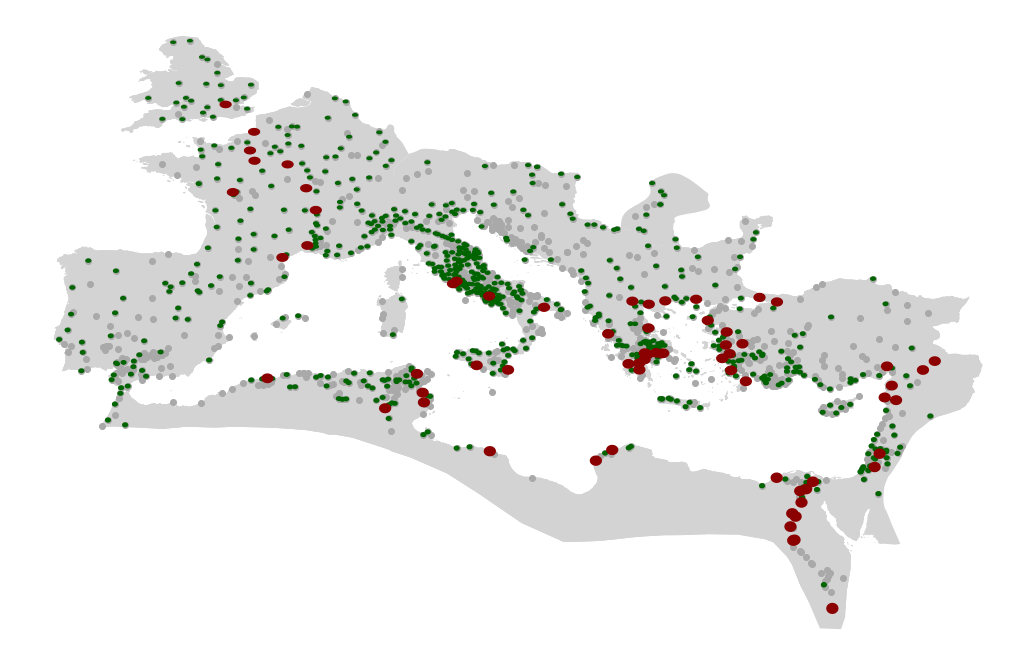

In [47]:
fig, ax = plt.subplots(figsize=[24, 12])
pleiades_regions.plot(ax=ax, color="lightgray")
cities_pop.plot(ax=ax, color="darkgrey")
cities_rest.plot(ax=ax, color="darkgreen")
cities_big.plot(ax=ax, color="darkred")
ax.set_axis_off()
#EDHg.plot(ax=ax, alpha=0.4, markersize=0.5)

In [82]:
### some inspiration from here
# https://gis.stackexchange.com/questions/349637/given-list-of-points-lat-long-how-to-find-all-points-within-radius-of-a-give

In [48]:
cities_big_multipolygon = cities_big["geometry"].unary_union
cities_rest_multipolygon = cities_rest["geometry"].unary_union

In [49]:
# for each inscription, decide whether it is in the multipolygon or not 
edh_big_cities_series = EDHg.within(cities_big_multipolygon)
edh_middle_cities_series = EDHg.within(cities_rest_multipolygon)

# working df with the same length as EDH
in_cities_df = pd.DataFrame([edh_big_cities_series, edh_middle_cities_series]).T
in_cities_df.columns = ["in_big", "in_middle"]
in_cities_df.head()

,in_big,in_middle
1,True,True
2,False,True
3,False,False
4,True,True
5,False,False


In [50]:
# for each inscription, decide whether it is in the multipolygon or not 
edcs_big_cities_series = EDCSg.within(cities_big_multipolygon)
edcs_middle_cities_series = EDCSg.within(cities_rest_multipolygon)

# working df with the same length as EDCS
in_cities_df_edcs = pd.DataFrame([edcs_big_cities_series, edcs_middle_cities_series]).T
in_cities_df_edcs.columns = ["in_big", "in_middle"]
in_cities_df_edcs.head()

,in_big,in_middle
2,True,False
3,False,False
4,False,False
5,False,False
6,False,False


In [51]:
# working df 
def get_big_middle_rest(row):
    value = "rest"
    if row["in_middle"]:
        value = "middle"
    if row["in_big"]:
        value = "big"
    return value

EDHg["urban_context"] = in_cities_df.apply(lambda row: get_big_middle_rest(row), axis=1)
EDCSg["urban_context"] = in_cities_df_edcs.apply(lambda row: get_big_middle_rest(row), axis=1)

In [82]:
# for future usage elsewhere, let's add this to the original dataset
urban_contexts_edh_dict = dict(zip(EDHg["id"].tolist(), EDHg["urban_context"].tolist()))
sddk.write_file("SDAM_data/social_diversity/urban_contexts_edh_dict.json", urban_contexts_edh_dict, conf)

urban_contexts_edcs_dict = dict(zip(EDCSg["EDCS-ID"].tolist(), EDCSg["urban_context"].tolist()))
sddk.write_file("SDAM_data/social_diversity/urban_contexts_edcs_dict.json", urban_contexts_edcs_dict, conf)

A file with the same name ("urban_contexts_edh_dict.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/urban_contexts_edh_dict.json"
A file with the same name ("urban_contexts_edcs_dict.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'dict'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/urban_contexts_edcs_dict.json"


In [439]:
def get_urban_context(id, dataset_name):
    if dataset_name == "EDH":
        try: return urban_contexts_edh_dict[id]
        except: return "unknown"
    if dataset_name == "EDCS":
        try: return urban_contexts_edcs_dict[id]
        except: return "unknown"
        
EDHg["urban_context"] = EDHg["id"].apply(lambda x: get_urban_context(x, "EDH"))
EDCSg["urban_context"] = EDCSg["EDCS-ID"].apply(lambda x: get_urban_context(x, "EDCS"))

In [448]:
print("EDH inscriptions in big cities: ", len(EDHg[EDHg["urban_context"]=="big"]))
print("EDH inscriptionslen in middle cities: ", len(EDHg[EDHg["urban_context"]=="middle"]))
print("EDH inscriptions - rest: ", len(EDHg[EDHg["urban_context"]=="rest"]))

EDH inscriptions in big cities:  3850
EDH inscriptionslen in middle cities:  23733
EDH inscriptions - rest:  25125


In [449]:
print("EDCS inscriptions in big cities: ", len(EDCSg[EDCSg["urban_context"]=="big"]))
print("EDCS inscriptionslen in middle cities: ", len(EDCSg[EDCSg["urban_context"]=="middle"]))
print("EDCS inscriptions - rest: ", len(EDCSg[EDCSg["urban_context"]=="rest"]))

EDCS inscriptions in big cities:  41799
EDCS inscriptionslen in middle cities:  31981
EDCS inscriptions - rest:  9876


In [446]:
sddk.write_file("SDAM_data/social_diversity/EDH_filtered.json", pd.DataFrame(EDHg.drop("geometry", axis=1)), conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDH_filtered.json"


In [447]:
sddk.write_file("SDAM_data/social_diversity/EDCS_filtered.json", pd.DataFrame(EDCSg.drop("geometry", axis=1)), conf)

Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/EDCS_filtered.json"
